In [1]:
import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from data.data_preparer import DataPreparer
from data.data_reader import DataReader
from predictor.implementations.multilayer_perceptron import MultiLayerPerceptronPredictor
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset
from tools.config_parser import ConfigParser
from tools.restaurant_profiles_manager import RestaurantProfilesManager
from tools.user_profiles_manager import UserProfilesManager
from tools.model_loader import ModelLoader

logging.basicConfig(level=logging.INFO)
while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [2]:
_, (b_test, r_test, u_test) = DataReader().read_data()

In [3]:
def load_model_with_test_data(model_path: os.PathLike, b_test_f, r_test_f, u_test_f) -> tuple[MultiLayerPerceptronPredictor, tuple[pd.DataFrame, pd.Series]]:
    # Create valid trained model
    trained_model = ModelLoader.load_mlp_model(model_path)
    # Create associated test data for validation
    input_test, output_test = DataPreparer.transform_data(b_test_f, r_test_f, u_test_f, trained_model.user_profiles_params, trained_model.business_profiles_params)

    return trained_model, (input_test, output_test)


def find_worst_model_with_index(model_list) -> tuple[float, int]:
    highest_loss = max([model_f[1] for model_f in model_list])
    corresponding_index = [i for i, model_f in enumerate(model_list) if model_f[1] == highest_loss][0]
    return highest_loss, corresponding_index


# For analysing trained models with different input vector, such as different user profiles
def get_all_models_with_loss():
    models_dir = [dir_entry.path for dir_entry in list(os.scandir(ConfigParser().get_value("predictor_model", "model_dir"))) if dir_entry.path.endswith('.pt')]
    models_with_loss_f = []
    for _ in range(len(models_dir)):
        models_with_loss_f.append((None, 99))
    for model_path in tqdm(models_dir, desc="Loading in models"):

        model_f, train_test_data_f = load_model_with_test_data(model_path, b_test, r_test, u_test)

        highest_loss, highest_index = find_worst_model_with_index(models_with_loss_f)
        current_loss = min(model_f.loss_history)
        if current_loss < highest_loss:
            models_with_loss_f[highest_index] = (model_f, current_loss, train_test_data_f)
    models_with_loss_f = sorted(models_with_loss_f, key=lambda data: data[1])
    return models_with_loss_f

# For analysing trained models with the same input vector, such as the best user profiles
def get_all_models_best_data():
    models_dir = [dir_entry.path for dir_entry in list(os.scandir(ConfigParser().get_value("predictor_model", "model_dir"))) if dir_entry.path.endswith('.pt')]
    models_with_loss_f = []
    for _ in range(len(models_dir)):
        models_with_loss_f.append((None, 99))

    # Load data
    input_test, output_test = DataPreparer.transform_data(b_test, r_test, u_test, UserProfilesManager().get_best(), RestaurantProfilesManager().get_best())
    for model_path in tqdm(models_dir, desc="Loading in models"):
        model_f = ModelLoader.load_mlp_model(model_path)
        highest_loss, highest_index = find_worst_model_with_index(models_with_loss_f)
        current_loss = min(model_f.loss_history)
        if current_loss < highest_loss:
            models_with_loss_f[highest_index] = (model_f, current_loss, (input_test, output_test))
    models_with_loss_f = sorted(models_with_loss_f, key=lambda data: data[1])
    return models_with_loss_f

In [4]:
models_with_loss = get_all_models_best_data()  # Collecting trained models for analysis with the same input vector, such as the best user profiles
# models_with_loss = get_all_models_with_loss()  # Collecting trained models for analysis with different input vector, such as different user profiles

results = []

INFO:root:Splitting in generation and prediction sets
INFO:root:Creating User Profile
INFO:root:Finished reading in data, starting NLP...
INFO:root:Loading in all scores...
INFO:root:Merging Reviews...
INFO:root:Loading in NLP model...
INFO:root:Calculating bert_scores...


Pandas Apply:   0%|          | 0/475422 [00:00<?, ?it/s]

INFO:root:creating user profiles from bert_scores...
INFO:root:Exploding bert_scores (late) & normalizing user profiles...


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Saving user profiles...
INFO:root:Saved user profiles with name: profile_tmp.parquet
INFO:root:Creating Restaurant Profile
INFO:root:Finished reading in data, starting NLP...
INFO:root:Loading in all scores...
INFO:root:Merging Reviews...
INFO:root:Loading in NLP model...
INFO:root:Calculating bert_scores...


Pandas Apply:   0%|          | 0/475422 [00:00<?, ?it/s]

INFO:root:creating user profiles from bert_scores...
INFO:root:Exploding bert_scores...
INFO:root:Saving business profiles...
INFO:root:Saved business profiles with name: profile_tmp.parquet
INFO:root:Transforming to ML input


Loading in models:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:root:Model loaded from predictor/Models/mlp\mlp1_2023-05-15_22h05__EPOCHS=30_LOSS=0.0842.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp2_2023-05-15_22h09__EPOCHS=30_LOSS=0.0916.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp3_2023-05-15_22h12__EPOCHS=30_LOSS=0.0974.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp4_2023-05-15_22h16__EPOCHS=30_LOSS=0.0962.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp5_2023-05-15_22h20__EPOCHS=30_LOSS=0.0793.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp6_2023-05-15_22h24__EPOCHS=30_LOSS=0.0766.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp7_2023-05-15_22h28__EPOCHS=30_LOSS=0.0777.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp8_2023-05-15_22h32__EPOCHS=30_LOSS=0.0757.pt.


In [5]:
# Run small testset on all the models to evaluate performance in a true recommendation environment

for model, _, train_test_data in models_with_loss:
    logging.info(f"Testing model with User Profiles: {model.user_profiles_params} and Business Profiles: {model.business_profiles_params}")
    model.eval()  # Prepare layers of model for evaluation
    with torch.no_grad():
        testX, testY = train_test_data

        testX = testX.head(500)
        testY = testY.head(500)

        dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
        test_loader = DataLoader(dl, batch_size=500)
        for x, y in test_loader:
            # Prepare data
            x, y = DataPreparer.get_tensor_for_ml(x, y)
            # Compute predictions and loss

            predictions = model(x)
            predictions = predictions.cpu().detach().numpy().squeeze().transpose()
            y = y.cpu().detach().numpy().squeeze().transpose()
            result = pd.DataFrame(data=[predictions, y]).transpose()
            result.columns = ['predicted', 'actual']
            result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
            result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
            result['difference'] = abs(result['predicted'] - result['actual'])
            results.append(result)

INFO:root:Testing model with User Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False} and Business Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': True, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False}
INFO:root:Testing model with User Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False} and Business Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': True, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False}
INFO:root:Testing model with User Profiles: {'current_model_name': 'online_model

Histogram of differences between prediction and actual:
Model used: <class 'predictor.implementations.multilayer_perceptron6.MultiLayerPerceptron6Predictor'>


,predicted,actual,difference
0,4,3,1
1,4,2,2
2,4,5,1
3,4,4,0
4,4,5,1
...,...,...,...
495,4,3,1
496,4,4,0
497,4,5,1
498,4,2,2


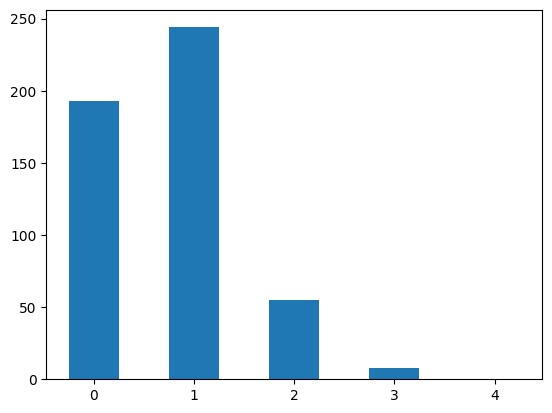

In [6]:
index = 1
result = results[index]
model: MultiLayerPerceptronPredictor = models_with_loss[index][0]
print("Histogram of differences between prediction and actual:")
print(f"Model used: {model.__class__}")
plt.hist(result['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5)
result

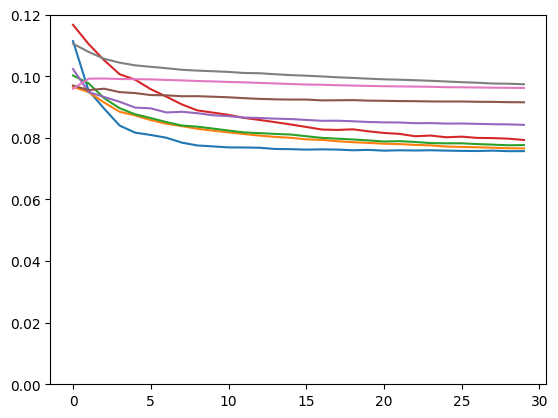

In [7]:
plot = plt.plot(models_with_loss[0][0].loss_history)
for model_i, _, _ in models_with_loss[1:]:
    plot += plt.plot(model_i.loss_history)
plt.ylim(0, 0.12)
plot